# Power Curve Estimation using Deep Learning
Emer Rodriguez-Formisano - _March 2018_

## Summary
The notebook shows how to apply Deep Learning techniques for predicting the power generated by a wind turbine. To challenge the Deep Neural Network (DNN), a state-of-the-art reference model was used from the literature which presents an Additive Multivariate Kernel method (AMK). The analysis shows that both methods obtain similar prediction performance.


## Introduction
**Deep learning** (DL) is a subset of techniques in the machine learning/AI field that attempts to learn patterns from data using algorithms that are not task-specific (generic). The algorithms are usually based on artificial neural networks made of several hidden layers, hence the word "deep", with also a large number of neurons<sup>[1](#ref1)</sup>. The deeper the network, the higher the model complexity together with its level of abstraction capabilities.

Traditionally, the data scientists had to use statistical techniques and expertise in order to obtain the hand-crafted features, but DL is able to identify and learn the features on its own during the training phase. The approach has been successfully applied to classification tasks in the field of computer vision and voice recognition but it can also be applied to regression tasks such as prediction.

The aim of this notebook is to **experiment and learn** how to apply the Deep Learning methods for **predicting the power generated by a wind turbine using its power curve data**. For those outside the wind industry, power curves represent the relationship between the electricity generated by the wind turbine and the wind speed at a given time<sup>[2](#ref2)</sup>. Besides _predicting the production of wind power_, power curves are also used for _monitoring the production efficiency_ of the wind turbines. 

To challenge the Deep Learning approach, a state-of-the-art reference model was used. In 2015, Lee et al. presented an additive multivariate kernel (AMK) method for power curve estimation<sup>[3](#ref3)</sup>. They did not only write an excellent article but also they make the results reproducible by published the dataset used together with the algorithm in an R package called _kerplus_<sup>[4](#ref4)</sup>. This provided a valuable baseline for the analysis.

The rest of the document is structured as follows. First, the datasets used for training the models are presented together with some visualizations. The second part contains the details about the Neural Network architecture, the hyperparameters selection and the results obtained. The last part contains a brief discussion and the comparison between the DL approach with the paper.

### Python Environment setup

In [1]:
import pandas as pd
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable Tensorflow GPU

from keras.models import Sequential, load_model
from keras.initializers import he_normal
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
pd.set_option('display.width', 1000)

Using TensorFlow backend.


## Dataset

High quality public available datasets about wind turbine power curves are extremely rare. My sincere gratitude to Lee et al. for sharing the J53 dataset on the Internet. The data is made of 1 year of 10-minute records from 6 Wind Turbines (4 onshore and 2 offshore). For the present analysis, 2 subsets are going to be used. One is the subset contained in the the R package called _windpw_<sup>[4](#ref4)</sup>. The second subset is all datapoint that belongs to the Wind Turbine 1 (WT1).

#### Dataset description 

| Dataset name  | Num. of records| Num. of variables | Traning size | Test size | Comments                             |
|:-------------:|--------------- | ----------------- | ------------ | --------- |:------------------------------------ |
| windpw        | 1000           | 6                 | 900          | 100       | Random sample from J53 dataset (WT1) |
| WT1           | 47542          | 7                 | 42787        | 4755      | All WT1 datapoints from J53 dataset  |

Note: a quick check of the windpw dataset showed that all its records belong to WT1. Most of them also appear in WT2 because both turbines share the same meteorological mast. 
```R
> table(plyr::match_df(J53_data[,c(id.cov, "WT", "seqNo")],windpw[,id.cov])$WT)
Matching on: V, D, rho, I, Sb

 WT1  WT2  WT3  WT4  WT5  WT6 
1000  972    0    0    0    0 
```

#### Dataset variables

| Codename | Name | Units | Description |
| --- | --- | --- | --- | 
| V | wind speed | m/s | |
| D | wind direction | degree | | 
| rho | air density | kg/m^3 | |
| I | turbulence intensity | | Coeff. of Variation in 10 min intervals I = std(V)/mean(V) |
| Sb | below-hub wind shear | | | 
| y | power | % | normalised power output relative to the rated power |
| seqNo | sequence number | | Sequence that orders the records with respect to time (only available in WT1) |

### Data Loader


In [2]:
WT_TYPES = {"WT1": "shore", "WT2": "shore", "WT3": "shore", "WT4": "shore",
            "WT5": "offshore", "WT6": "offshore"}

J53_VARNAMES = {"Sequence No.": "seqNo", "air density": "rho", "Humidity": "H",
                "S_a": "Sa", "S_b": "Sb", "y (% relative to rated power)": "y"}

def read_J53_data(dir):
    data_list = list()
    for dirpath, _, filenames in os.walk(dir):
        for f in filenames:
            fullpath = os.path.abspath(os.path.join(dirpath, f))
            logger.info("Reading data from: {}".format(fullpath))
            df = pd.read_csv(fullpath, header=0, sep=" ", index_col="Sequence No.")
            df.rename(columns=J53_VARNAMES, inplace=True)
            id = f.split("_")[1].split(".")[0]
            df["WT"] = id
            df["Type"] = WT_TYPES[id]

            data_list.append(df)
    data = pd.concat(data_list)
    return data

# Load J53 Data
J53_data = read_J53_data("PCEDL/data/J53")

def get_dataset(name="WT1"):
    # Name is one of: windpw or WT1
    if(name == "WT1"):
        # Select WT1 data and get order to match R analysis
        wt_data = J53_data.loc[J53_data["WT"] == "WT1",
                               ["V", "D", "rho", "I", "Sb", "y"]]
        wt1_order = pd.read_csv("R/WT1_seqNo_order.csv", header=0)
        wt_data = wt_data.loc[wt1_order["seqNo"], :]

    else:
        # Default dataset: windpw from kernplus R package
        wt_data = pd.read_csv("R/kernplus_windpw.csv")
    
    return wt_data


In [3]:
wt_data = get_dataset("windpw")
wt_data.describe()

,V,D,rho,I,Sb,y
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.561050,201.95428,1.192818,0.093165,0.243746,52.483180
std,2.877354,90.07896,0.047847,0.054091,0.240803,34.240619
min,3.550000,0.00000,1.109568,0.014839,-0.666431,-0.990000
25%,6.210000,150.12500,1.153046,0.055157,0.092509,19.730000
50%,8.385000,200.15000,1.187288,0.083725,0.217664,51.260000
75%,10.510000,278.42500,1.229758,0.117510,0.379841,85.725000
max,18.780000,359.10000,1.327432,0.385042,1.373158,101.560000


## Data visualization
### Power Curve

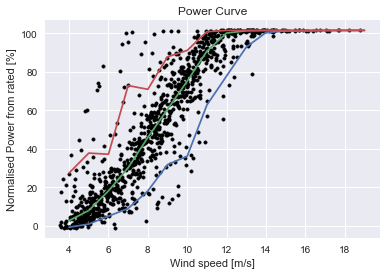

In [4]:
# Scatter style
plt.scatter(wt_data["V"], wt_data["y"], marker='.', color='k')
wt_plot = wt_data.copy()
wt_plot = wt_plot[["V", "y"]]
wt_plot = wt_plot.assign(V=wt_plot["V"].round(0))
def q1(x):
    return np.percentile(x, 5)
def q2(x):
    return np.percentile(x, 50)
def q3(x):
    return np.percentile(x, 95)

lines_data = wt_plot.groupby(by="V").agg({"y": [q1, q2, q3]})
plt.plot(lines_data)
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Normalised Power from rated [%]")
plt.title("Power Curve")
plt.show()

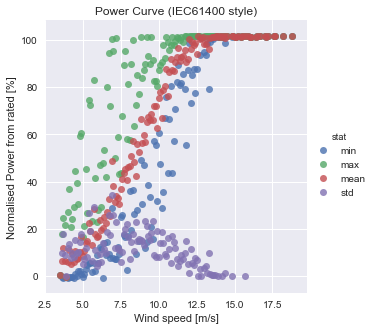

In [5]:
# IEC61400 style
wt_plot = wt_data.copy()
wt_plot = wt_plot[["V", "y"]]
bin_size = 0.1
wt_plot = wt_plot.assign(V=(wt_plot["V"]/bin_size).round(0)*bin_size) # Round to bin size
agg_data = wt_plot.groupby(by="V").agg({"y": ['min', 'max', 'mean', 'std']})
agg_data = agg_data.unstack().reset_index()
agg_data.columns = ["label", "stat", "V", "y"]
sns.lmplot(x="V", y="y", data=agg_data, fit_reg=False, hue="stat", size=4.5)
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Normalised Power from rated [%]")
plt.title("Power Curve (IEC61400 style)")
plt.show()

### Pairwise Scatterplots
Useful for having a visual idea about the relationships between the variables.

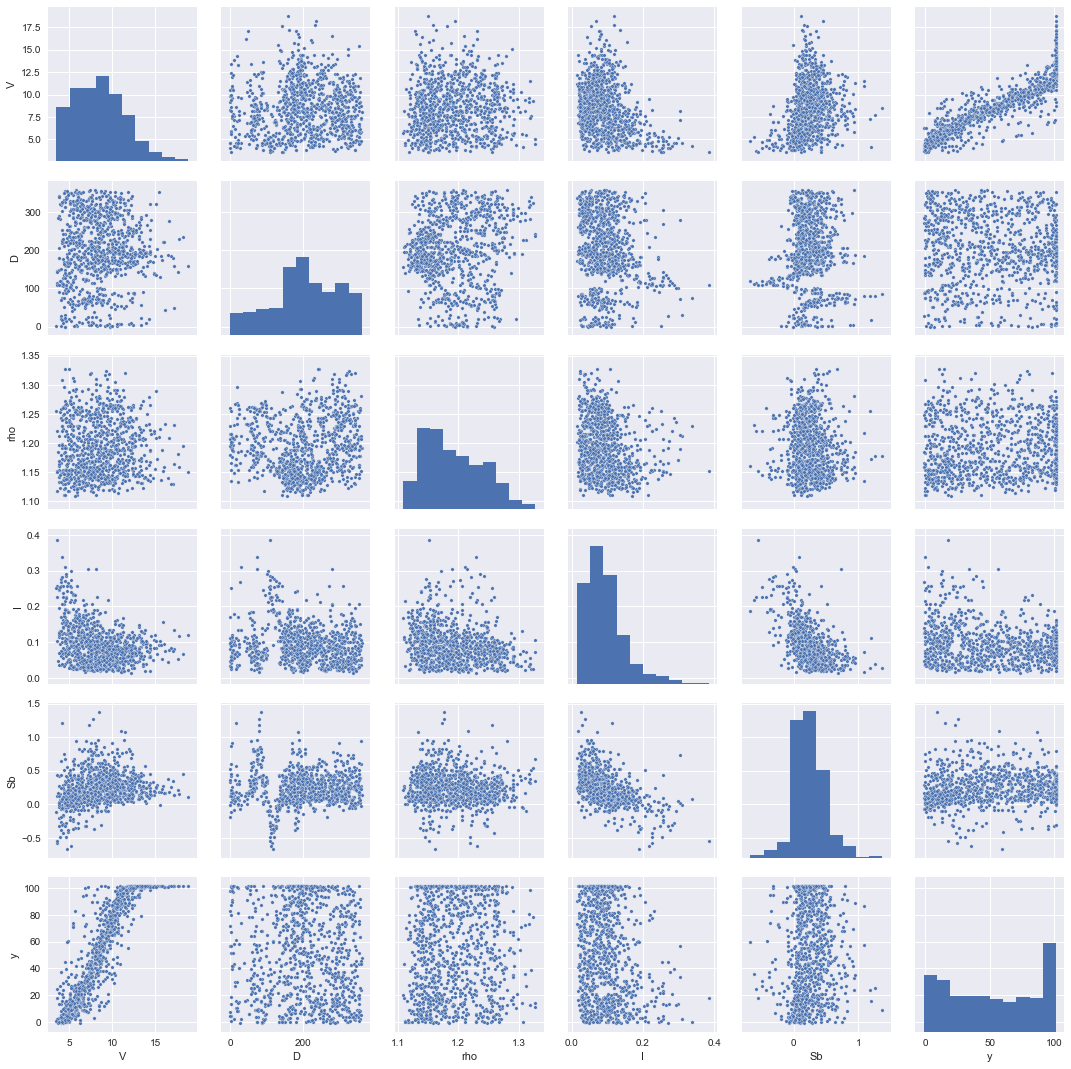

In [6]:
g = sns.pairplot(wt_data, markers='.')

## Preprocess
As the data was used in a previous analysis, it is clean and ready to use. The only manipulations done in this section is the split of training (90%) and test (10%) datasets, and the standardisation of the variables. 

In [7]:
def apply_preprocess(data):
    # Preprocess (no missing values)
    X = data[["V", "D", "rho", "I", "Sb"]]
    Y = data["y"]

    train_size = int(data.shape[0] * 0.9)
    test_size = data.shape[0] - train_size

    X_train = X.iloc[np.arange(train_size)]
    Y_train = Y.iloc[np.arange(train_size)]
    X_test = X.iloc[train_size + np.arange(test_size)]
    Y_test = Y.iloc[train_size + np.arange(test_size)]

    # Standardise (Xstd = X-mean(X)/std(X))
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()
    
    return X_train, Y_train, X_test, Y_test


## DNN Model
As previously introduced, the model proposed is an Artificial Neural Network which can be considered a Deep Neural Network (DNN) when multiple hidden layers are used. The challenge is finding an optimal set of hyperparameters and architecture which minimises the prediction error. The list of hyperparameters is large and the optimal values are dependent on the problem and the data and also between themselves. Thus, the iteration process is based on trial and error and it can be very time-consuming. However, different sets of settings tend to provide similar performance and also some recommendations can be extracted from the literature. 

Here is a list of some of the hyperparameters considered during the analysis:
- Number of layers
- Number of nodes per layer
- Number of epochs
- Batch size
- Activation function
- Weight initialisation
- Loss function
- Optimiser
- Learning rate
- Dropout rate

Starting with a simpler model using a single layer with a few nodes is recommended. If the model has underfitting problems, the complexity can be increased by adding more nodes. The number of epochs and batch size are related and sensitive to the number of nodes. The activation function used is a rectified linear unit (ReLU) which works well when using He normal weight initializer. The loss function usually used for regression is the Mean Square Error. There are several optimisers but Adam and Nadam which use adaptive learning rates provide good performance. The Dropout rate helps to control the generalization of the trained model. 

### Model definition and fitting function
The function outputs a summary of the model defined based on the hyperparameters provided. Then it fits the model using the training data. The model, the historic performance an a codename of the run are returned.

In [8]:
def define_and_fit_model(layer_nodes, num_epochs, batch, optimiser, dropout_rate=0, input_nodes=5):
    
    num_layers = len(layer_nodes)
    
    ### Define Model ###
    model = Sequential()
    first = True
    for l in range(num_layers):
        if first:
            # Input layer
            model.add(Dense(layer_nodes[l], input_dim=input_nodes,
                            kernel_initializer=he_normal(seed=1),
                            # kernel_regularizer=regularizers.l2(0.1),
                            activation='relu'))
            first = False
            
        else:
            # Hidden layers
            model.add(Dense(layer_nodes[l],
                            kernel_initializer=he_normal(seed=1),
                            # kernel_regularizer=regularizers.l2(0.1),
                            activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
            
    # Output layer
    model.add(Dense(1, kernel_initializer=he_normal(seed=1)))
    
    print(model.summary())
    
    ### Fit Model ###
    model.compile(loss='mean_squared_error', optimizer=optimiser)
    checkpoint = ModelCheckpoint("model.hdf5", monitor='val_loss', verbose=0,
                                 save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    history = model.fit(X_train, Y_train, 
                        epochs=num_epochs, batch_size=batch, verbose=0,
                        # validation_split=0.2,
                        validation_data=(X_test, Y_test),
                        callbacks=callbacks_list)

    run_codename = "run__{layers}__b{batch_size}__{opt}__d{drop}__e{epochs}".format(
        layers="_".join(map(str, layer_nodes)), batch_size='%04d' % batch, opt=optimiser, 
        drop=('%.4f' % 0.01).replace('.','_'), epochs= '%05d' % batch)
    
    return model, history, run_codename


### Model Evaluation function
The evaluation function checks the performance of the fitted model by comparing the Mean Squared Error with the measurements obtained from the AMK model. It additionally plots: 
- The performance of the training process
- The residuals plot against the predicted values
- The distribution of the errors of both models
- The distribution of the Squared Error differences (DNN-AMK). 

A parametric and non-paramteric test was also included in order to show the statistical significance of the differences.  

In [9]:
def evaluate_model(history, model, dataset_name, codename):
    hist = pd.DataFrame(history.history, index=history.epoch)
    ### Load AMK reference data ###
    if dataset_name == "WT1":
        ypred_AMK = pd.read_csv("R/WT1_test_pred_AMK.csv", header=0)
        ypred_AMK = ypred_AMK["WT1_test_pred_AMK"]
        hist["val_AMK"] = 56.0239
        hist["AMK"] = 37.76508
        ylim = [0, 200]

    elif dataset_name == "windpw":
        ypred_AMK = pd.read_csv("R/windpw_test_pred_AMK.csv", header=0)
        hist["val_AMK"] = 133.0267
        hist["AMK"] = 72.9650
        ylim = [50, 300]

    AMK_errors = Y_test.values.reshape(ypred_AMK.shape) - ypred_AMK
    AMK_errors = np.array(AMK_errors).flatten()

    ### DNN Summary ###
    # Current state model
    ypred = model.predict(X_test)
    y = Y_test.values.reshape(ypred.shape)
    mse = np.mean(np.power(y - ypred, 2))
    print("Current model (test)\n MSE: {} \nRMSE: {}\n".format(
        mse, np.sqrt(mse)))

    # Lowest MSE Model
    lowest_mse_model = load_model("model.hdf5")
    ypred = lowest_mse_model.predict(X_test)
    DNN_errors = np.array(y - ypred).flatten()
    DNN_mse = np.mean(np.power(y - ypred, 2))
    DNN_rmse = np.sqrt(DNN_mse)
    
    best_epoch = hist[hist["val_loss"] == hist["val_loss"].min()]
    print("Best epoch: {}\n"
          "Min Validation MSE: {}\n"
          "Min Validation RMSE: {}".format(
              best_epoch.index.values[0], DNN_mse, DNN_rmse))
    
    AMK_mse = hist["val_AMK"].values[0]
    AMK_rmse = np.sqrt(AMK_mse)
    print("Reference MSE (AMK): {}\n"
          "Reference RMSE (AMK): {}".format(AMK_mse, AMK_rmse))
    # The Lowest MSE model is used in the following analysis

    # MSE plot
    hist_ax = hist.plot()
    hist_ax.set_ylim(ylim[0], ylim[1])
    plt.legend(["Train DNN", "Test DNN", "Test AMK", "Train AMK"])
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.title("Model Performance")
    plt.show()

    filename = "{dataset}_{codename}.png".format(dataset=dataset_name,
                                                 codename=codename)
    hist_ax.get_figure().savefig(filename)

    # Residuals
    sns.residplot(np.array(ypred).flatten(), np.array(y).flatten(),
                  lowess=True)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals (DNN)")
    plt.show()

    # Error denstity distribution
    sns.kdeplot(AMK_errors, label="AMK", shade=True)
    sns.kdeplot(DNN_errors, label="DNN", shade=True)
    plt.xlabel("Error")
    plt.ylabel("Density")
    plt.title("Prediction error distribution")
    plt.show()

    # Statistical differences between models
    from scipy import stats
    DNN_sq_err = np.power(DNN_errors, 2)
    AMK_sq_err = np.power(AMK_errors, 2)
    # Paired t-test
    ttest = stats.ttest_rel(DNN_sq_err, AMK_sq_err)
    print("Paired t-test\n"
          "t: {}, p-value: {}\n"
          "mean of the differences: {}\n"
          "RMSE ratio: {}".format(
              np.round(ttest.statistic, 4), 
              ttest.pvalue,
              np.mean(DNN_sq_err - AMK_sq_err),
              np.round((DNN_rmse-AMK_rmse)/AMK_rmse, 4)))

    # Wilcoxon signed-rank test
    wtest = stats.wilcoxon(DNN_sq_err, y=AMK_sq_err, zero_method='wilcox',
                           correction=False)
    print("\nWilcoxon signed-rank test\nW: {}, p-value: {}".format(
        np.round(wtest.statistic, 4), wtest.pvalue))

    # Difference distribution
    sns.distplot(DNN_sq_err - AMK_sq_err, kde=False, rug=True,
                 label="DNN-AMK");
    plt.xlabel("Squared Error")
    plt.ylabel("Frequency")
    plt.title("Prediction difference between DNN and AMK distribution")
    plt.show()


## Results
Several runs with different settings were performed during the trial and error phase. However, for conciseness, only the relevant results are presented in the notebook. Other plots from the discovery phase can be found in the code repository<sup>[5](#ref5)</sup>.

## Dataset _windpw_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Current model (test)
 MSE: 130.79631615215402 
RMSE: 11.436621710634396

Best epoch: 893
Min Validation MSE: 128.1761114025687
Min Validation RMSE: 11.321488921629022
Reference MSE (AMK): 133.0267
Reference RMSE (AMK): 11.533720128388758


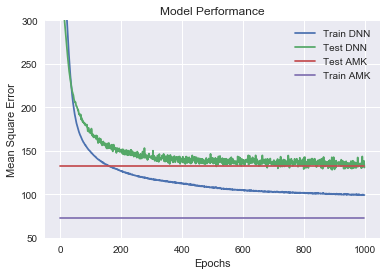

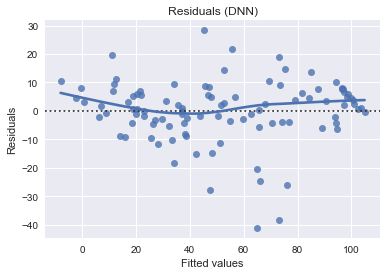

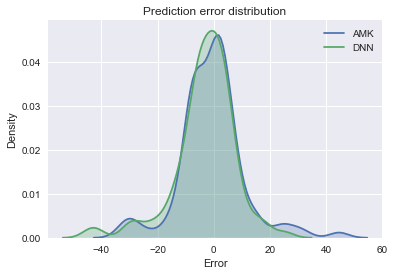

Paired t-test
t: -0.2013, p-value: 0.8408456052733178
mean of the differences: -4.850561494256536
RMSE ratio: -0.0184

Wilcoxon signed-rank test
W: 2498.0, p-value: 0.9260348271927795


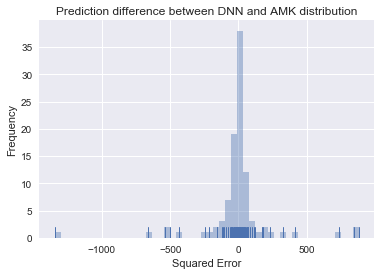

In [10]:
X_train, Y_train, X_test, Y_test = apply_preprocess(get_dataset("windpw"))
model, hist, name = define_and_fit_model(layer_nodes=[64], num_epochs=1000, batch=30, optimiser='nadam')
evaluate_model(hist, model, "windpw", name)

For the first and small dataset, the results of an ANN with a single hidden layer of 64 nodes are presented. The model obtains equivalent predicting performance as the AMK model without overtraining the training dataset. In other words, there is a narrower gap of the model performance between using the training subset and the test subset. Although the model with lowest RMSE shows around 2% of improvement over predictions of AMK, the difference is not statistically relevant.

## Dataset _WT1_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
None
Current model (test)
 MSE: 59.41640041001148 
RMSE: 7.708203448924495

Best epoch: 240
Min Validation MSE: 55.74335920560484
Min Validation RMSE: 7.466147547805685
Reference MSE (AMK): 56.0239
Reference RMSE (AMK): 7.484911489122633


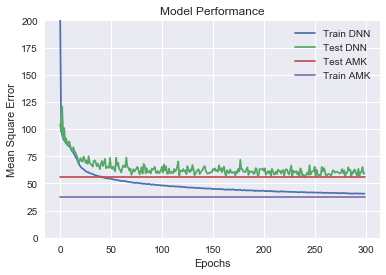

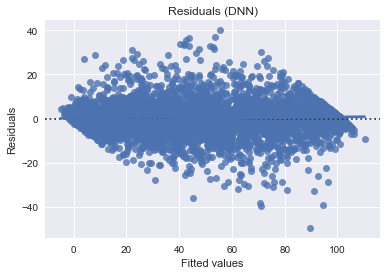

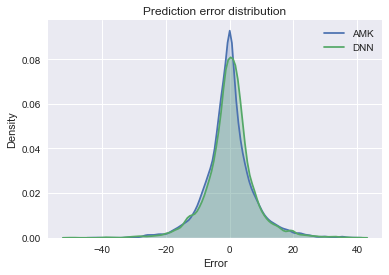

Paired t-test
t: -0.1946, p-value: 0.8456955918140613
mean of the differences: -0.2805662844068289
RMSE ratio: -0.0025

Wilcoxon signed-rank test
W: 5641953.0, p-value: 0.9012888810368194


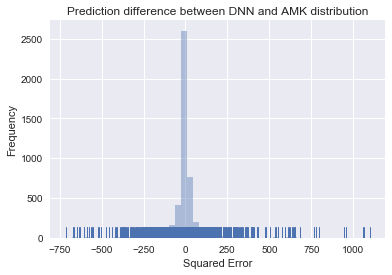

In [11]:
X_train, Y_train, X_test, Y_test = apply_preprocess(get_dataset("WT1"))
model, hist, name = define_and_fit_model(layer_nodes=[64, 64, 64], num_epochs=300, batch=30, optimiser='nadam')
evaluate_model(hist, model, "WT1", name)

For the second and larger dataset, the results of a DNN with three hidden layer of 64 nodes are presented. The model obtains equivalent predicting performance as the AMK model. Similar to the previous dataset, the prediction improvements are not statistically relevant.

A second run is proposed in order to improve the generalization capabilities. The aim is to reduce the gap performance between the training and the test sets.  The architecture is the same but only a dropout rate of 4/64 has been added. Now, during training, the algorithm will remove 4 random nodes in each layer. The method avoids overfitting by preventing co-dependencies between neurons during training. If a neuron cannot rely on the weights of other neurons, its own weights will then have to be more robust.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total para

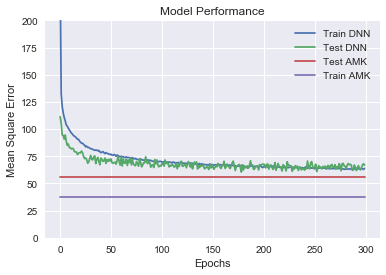

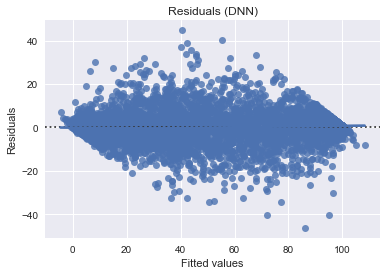

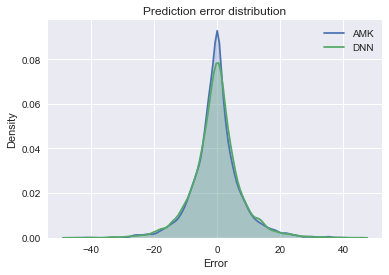

Paired t-test
t: 3.3195, p-value: 0.0009086474102818899
mean of the differences: 4.4788284525738495
RMSE ratio: 0.0392

Wilcoxon signed-rank test
W: 5129823.0, p-value: 3.1341014587269966e-08


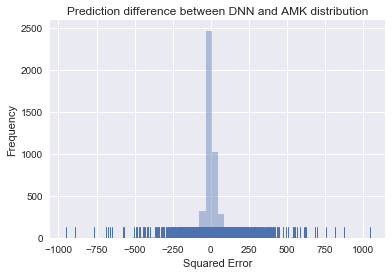

In [12]:
X_train, Y_train, X_test, Y_test = apply_preprocess(get_dataset("WT1"))
model, hist, name = define_and_fit_model(layer_nodes=[64, 64, 64], num_epochs=300, batch=30, optimiser='nadam', 
                                         dropout_rate=4/64)
evaluate_model(hist, model, "WT1", name)

The results with the dropout parameter show no visual gap between training and test subsets performance but at the cost of increasing the prediction error of this particular test subset. The prediction mean error of the DNN for the test subset is 3.6% bigger compared to the AMK model. However, the performance prediction of the model (without retraining) againsts other datasets is expected to be higher. Further experiments are required to prove this hypothesis.

## Conclusions

Both objectives have been achieved. First, the notebook shows how to apply DL methods for predicting the power generated by a Wind Turbine. Second, the analysis shows DL prediction performance compared to the non-parametric AMK model.

The DL method did not outperform the AMK technique but it reached the same prediction capabilities. This means that both methods are able to get all the juice from the data. Further work on the analysis could focus on several aspects. First, continue with the generalisation efforts and apply Cross Validation techniques to get a solid measure of the generalisation across multiple test sets. Secondly, have a closer look at the outliers detected in the density plots. DNN showed that some AMK estimations were improved but it also made worst predictions than AMK. Studying in which cases DNN was better than AMK and vice-versa, could lead to some hints about how to improve the models. DNN also tend to underestimate the power prediction (left tail was thicker) which may be better than overestimating it.

## References
<a name="ref1">[1]</a>: Brownlee, Jason. "What is Deep Learning?" Machine Learning Masteri. August 16, 2016. [Web](https://machinelearningmastery.com/what-is-deep-learning/). March 2018

<a name="ref2">[2]</a>: "Wind turbine power ouput variation with steady wind speed." Wind Power Program. [Web](http://www.wind-power-program.com/turbine_characteristics.htm). March 2018

<a name="ref3">[3]</a>: Lee, Ding, Genton, and Xie, 2015, “Power curve estimation with multivariate environmental factors for inland and offshore wind farms,” Journal of the American Statistical Association, Vol. 110, pp. 56-67. [[pdf]](http://aml.engr.tamu.edu/wp-content/uploads/sites/164/2017/11/J53.pdf) [[data]](https://tamucs-my.sharepoint.com/personal/yu-ding_tamu_edu/_layouts/15/guestaccess.aspx?docid=02ca342aff3b14e0b8267b2e8439d4ebb&authkey=AQZ_SN1Ra8BlDfPBfqraLlU&e=4c97b6b8ec3343beab3e42eae8354a69) _Note: The datasets shared here include the normalized power, a percentage relative to the rated power.  Some of the tables in the paper may not be precisely reproducible using the normalized power data.  But the relative performance of the methods should remain in the same order._ [Web](https://aml.engr.tamu.edu/2001/09/01/publications/). March 2018

<a name="ref4">[4]</a>: Yu Ding and Hoon Hwangbo (2017). kernplus: A Kernel Regression-Based Multidimensional Wind Turbine Power Curve. R package version 0.1.0. https://CRAN.R-project.org/package=kernplus

<a name="ref5">[5]</a>: Rodriguez-Formisano, Emer. PCEDL, GitHub repository. [Web](https://github.com/emerrf/PCEDL). March 2018